### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [32]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1) Initialize Model

In [27]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 100000

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [28]:
#'''

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 7) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/optimization_{}_{}.csv'.format(problem_formulation,nfe))

#'''

/usr/local/lib/python3.11/site-packages/ema_workbench/em_framework/evaluators.py:349: UserWarning: the number of processes cannot be more then 4
  warnings.warn(f"the number of processes cannot be more then {max_processes}")
[MainProcess/INFO] pool started with 4 workers
100%|████████████████████████████████████████| 200/200 [00:33<00:00,  5.93it/s]
[MainProcess/INFO] optimization completed, found 138 solutions
[MainProcess/INFO] terminating pool


In [29]:
# final result data set
results = pd.read_csv("results/optimization_6_200.csv")
results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,0,1,1,1,7,2,10,...,4.421502e+07,0.000000,0.000000e+00,1.426165e+07,0.000000,0.000000e+00,2.757823e+07,0.000000,377300000.0,111.521161
1,1,0,0,0,0,0,3,10,4,3,...,2.419803e+07,0.001189,2.761591e+07,6.320800e+06,0.000286,0.000000e+00,3.337712e+07,0.000000,0.0,515.238504
2,2,0,0,1,0,0,4,4,9,10,...,4.421502e+07,0.000000,0.000000e+00,9.695195e+06,0.000000,7.315192e+06,3.337712e+07,0.000129,30700000.0,82.493383
3,3,0,0,0,0,1,3,8,3,6,...,3.139880e+07,0.000000,2.622635e+07,6.320800e+06,0.000263,3.127222e+08,0.000000e+00,0.005371,256100000.0,3442.628826
4,4,1,0,0,0,0,1,10,6,5,...,2.879840e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,7.315192e+06,3.337712e+07,0.000386,84600000.0,34.282964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,133,1,0,0,1,1,2,6,5,4,...,2.640338e+07,0.000000,0.000000e+00,8.453408e+06,0.000000,1.941075e+08,0.000000e+00,0.004166,461900000.0,1540.775385
134,134,0,1,1,1,0,3,4,8,3,...,2.419803e+07,0.000000,0.000000e+00,2.038434e+07,0.000000,8.379476e+07,2.503721e+07,0.001448,369700000.0,821.912046
135,135,1,0,1,0,0,2,6,1,1,...,2.029929e+07,0.002818,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,5.817663e+07,0.000000,115300000.0,1009.785238
136,136,0,1,1,0,1,3,3,3,9,...,4.060905e+07,0.000000,0.000000e+00,9.695195e+06,0.000000,3.241672e+08,0.000000e+00,0.005583,504600000.0,3210.076680


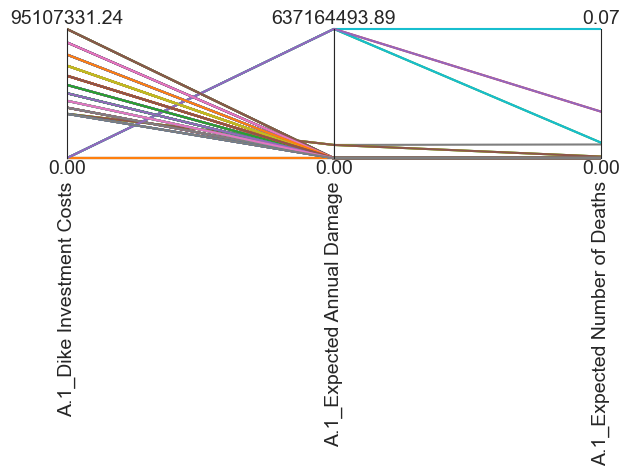

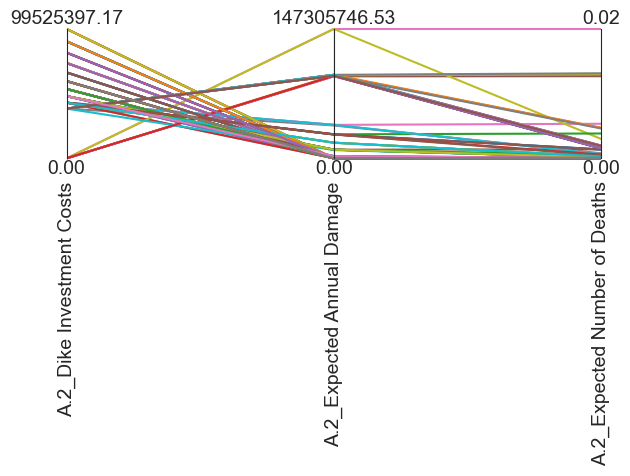

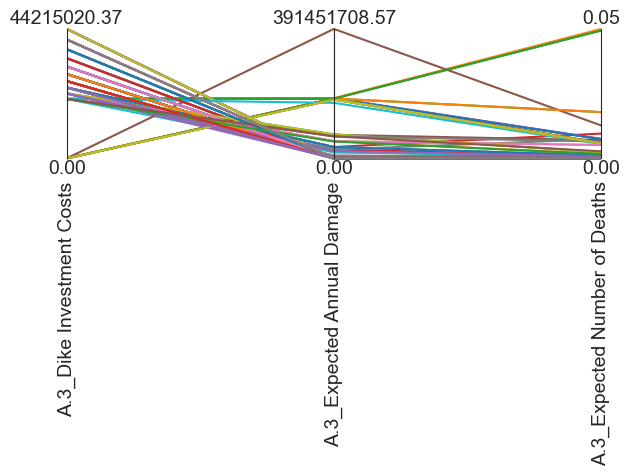

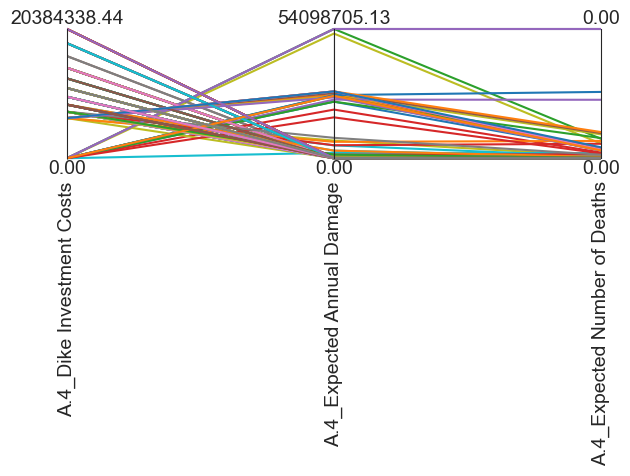

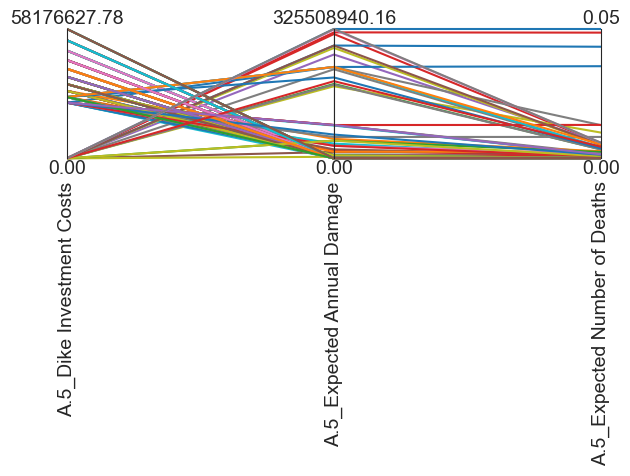

In [33]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = results.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [37]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)


results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
0,0,0,0,0,1,1,1,7,2,10,...,2.757823e+07,0.000000,377300000.0,111.521161,0.001512,2.735623e+07,1.551724e+08,0.000000,0.000000e+00,4.183988e+07
1,1,0,0,0,0,0,3,10,4,3,...,3.337712e+07,0.000000,0.0,515.238504,0.001189,3.433525e+07,1.726639e+08,0.000286,2.761591e+07,3.969792e+07
2,2,0,0,1,0,0,4,4,9,10,...,3.337712e+07,0.000129,30700000.0,82.493383,0.000000,0.000000e+00,1.820550e+08,0.000129,7.315192e+06,4.307231e+07
3,3,0,0,0,0,1,3,8,3,6,...,0.000000e+00,0.005371,256100000.0,3442.628826,0.000185,9.871992e+06,1.555406e+08,0.005634,3.389485e+08,6.320800e+06
4,4,1,0,0,0,0,1,10,6,5,...,3.337712e+07,0.000386,84600000.0,34.282964,0.000000,0.000000e+00,1.899508e+08,0.000386,7.315192e+06,4.444589e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,133,1,0,0,1,1,2,6,5,4,...,0.000000e+00,0.004166,461900000.0,1540.775385,0.000000,0.000000e+00,1.465308e+08,0.004166,1.941075e+08,8.453408e+06
134,134,0,1,1,1,0,3,4,8,3,...,2.503721e+07,0.001448,369700000.0,821.912046,0.000000,0.000000e+00,1.533234e+08,0.001448,8.379476e+07,4.542155e+07
135,135,1,0,1,0,0,2,6,1,1,...,5.817663e+07,0.000000,115300000.0,1009.785238,0.004922,1.603335e+08,1.192617e+08,0.000000,0.000000e+00,6.663004e+07
136,136,0,1,1,0,1,3,3,3,9,...,0.000000e+00,0.005583,504600000.0,3210.076680,0.000047,2.520716e+06,1.307433e+08,0.005583,3.241672e+08,9.695195e+06


In [39]:
#Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.2
distribution_threshold_damages = 0.2
distribution_threshold_investment = 0.2
#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Gelderland_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Gelderland_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]

policies

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
23,23,0,0,0,1,0,4,3,8,4,...,2.503721e+07,0.001448,121200000.0,958.897387,0.0,0.0,1.499723e+08,0.001448,8.379476e+07,4.542155e+07


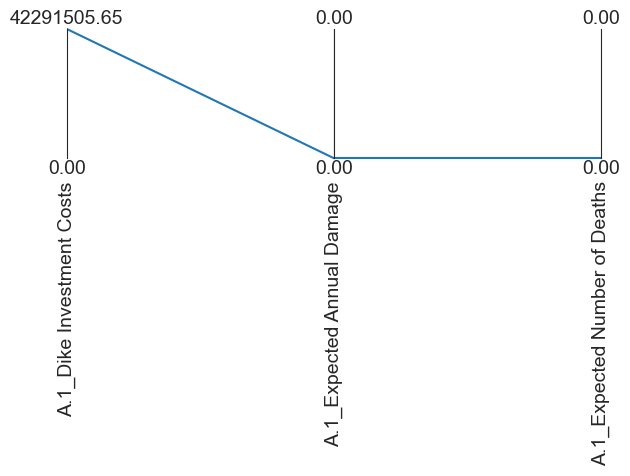

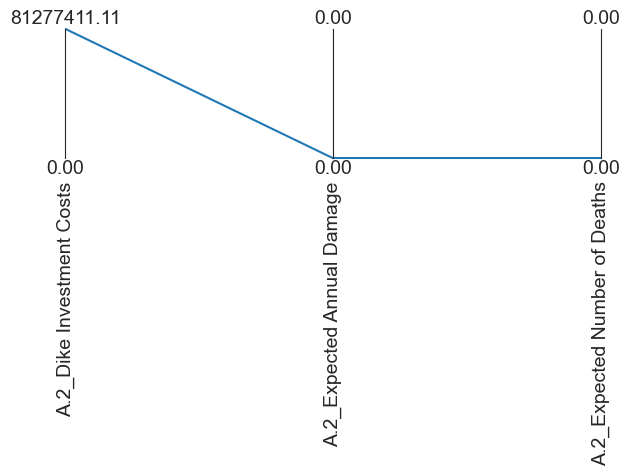

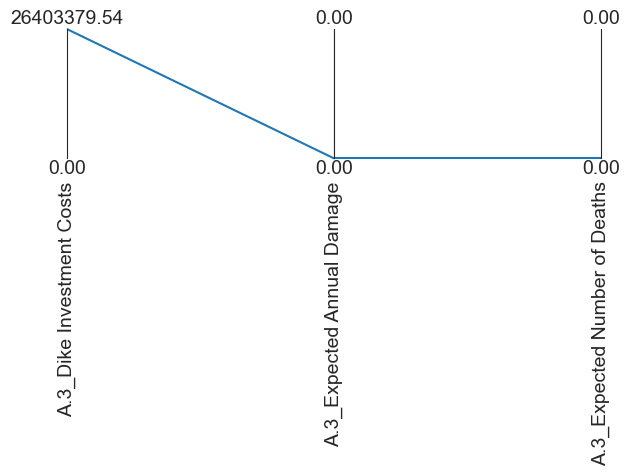

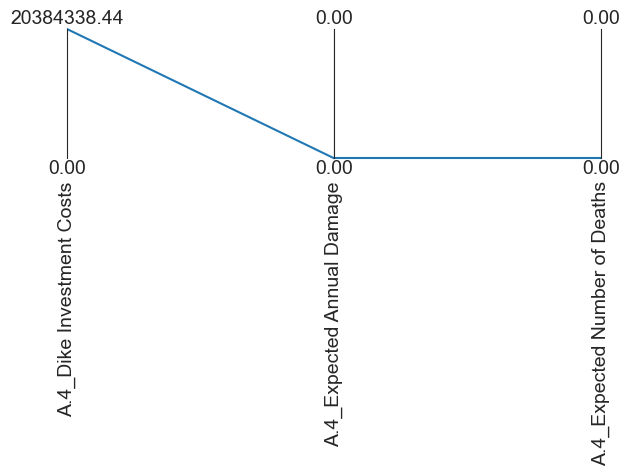

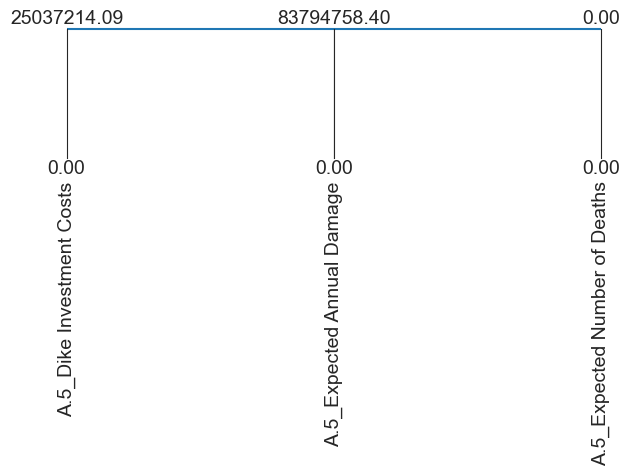

In [42]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = policies.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

#### 3b Robustness Analysis (Run Scenarios)

In [33]:
'''

n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2.tar.gz')

'''

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 9 policies * 1 model(s) = 900 experiments
100%|████████████████████████████████████████| 900/900 [04:44<00:00,  3.16it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [38]:
rob_results = load_results ('results/MORDM2.tar.gz')

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final assignment\results\MORDM2.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [39]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [40]:
experiments, outcomes = rob_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,1.674827e+17,2.540139e+01,0.074380
1,5.113118e+16,2.273073e+12,0.000640
3,1.220517e+17,3.204631e+12,0.000750
4,6.046720e+15,1.387078e+12,0.000051
5,7.119939e+16,4.138667e+12,0.001279
6,5.546707e+16,5.228207e+12,0.000676
7,1.569454e+16,2.763330e+12,0.000315
8,2.441684e+17,6.154787e+12,0.002618
9,1.415494e+17,3.527467e+12,0.000805


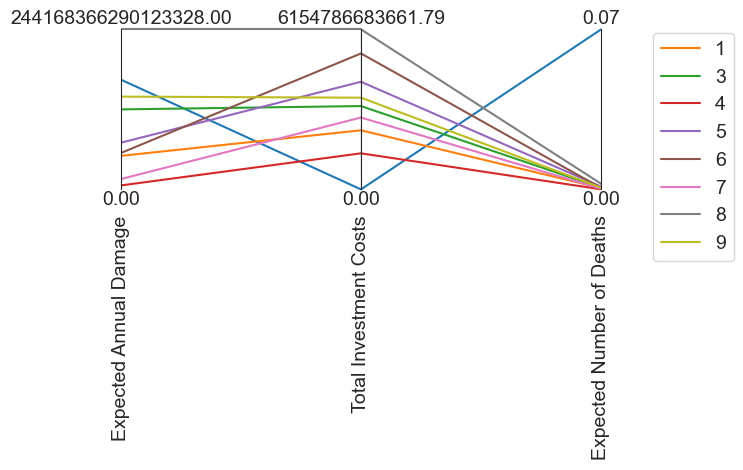

In [42]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
    paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])

paraxes.legend()

#paraxes.invert_axis('max_P')
plt.show()

##### 3c2 Calculate Regret

In [43]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [45]:
experiments, outcomes = rob_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


visualize as heatmap

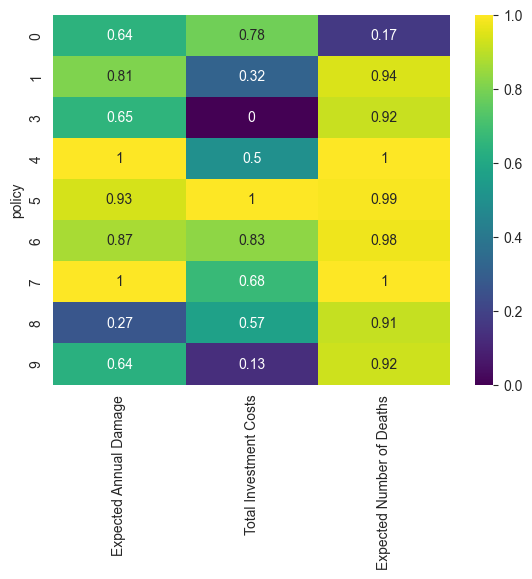

In [46]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

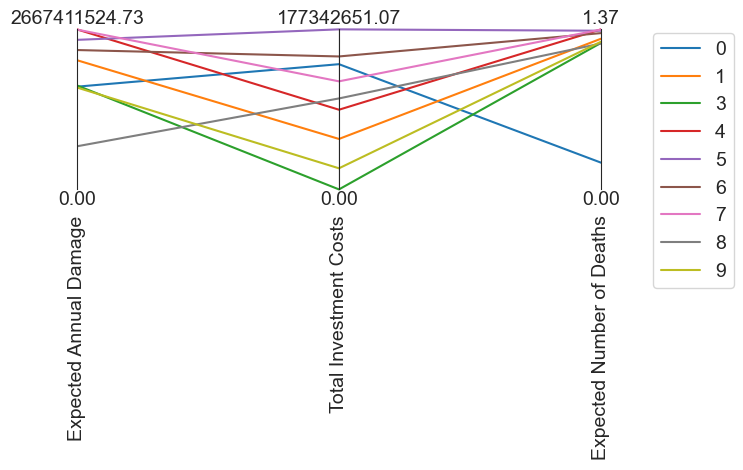

In [48]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

##### 3c3 Scenario Discovery for some conditions (IF NECESSARY)

In [51]:
'''

from ema_workbench.analysis import prim

x = 
y = 

prim_alg = prim.Prim(x, y, threshold=0.5)
box = prim_alg.find_box()

'''

NameError: name 'outcome_names' is not defined

In [ ]:
#box.inspect_tradeoff()

In [ ]:
#boxno = 2
#box.inspect(boxno)

In [ ]:
#box.select(boxno)